In [ ]:
# Z == solar units

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

In [2]:
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")
aexp = data.properties['a']
data.physical_units()
r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir
sph_5 = pynbody.filt.Sphere(radius = '5.0 kpc') # %(r_e*1.4))
region = data[sph_5]
rho = region.gas["rho"].in_units("m_p cm**-3")
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()
for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))
omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18


In [3]:
%%time
m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
dummy_length = pynbody.array.SimArray(1., "cm")
dummy_mass = pynbody.array.SimArray(1., "g")
turb = np.sqrt( region.g["turb"] * 2./3. ) * unit_l / unit_t / 1e5
turb = pynbody.array.SimArray(turb*1e5, units = "cm s**-1")
T = region.g["temp"]
c_s = np.sqrt(K_b * T_mean / m_p)

CPU times: user 326 ms, sys: 627 ms, total: 953 ms
Wall time: 948 ms


In [4]:
def make_pdf(s, s_bar, sigma_s):
    pdf = (1/np.sqrt(2*np.pi*(sigma_s**2))) * (np.exp(-0.5*(((s - s_bar)/sigma_s)**2)))
    return pdf

def calc_integral(s, pdf, X_H2, ds):
    integ = 0.0
    for i in range(0, 100):
        integ += (np.exp(s[i])*pdf[i]*X_H2[i]*ds)
    return integ

def calc_integral2(s, pdf, X_CO, ds):
    integ = 0.0
    for i in range(0, 100):
        integ += (np.exp(s[i])*pdf[i]*X_CO[i]*ds)
    return integ

def calc_lambda_jeans(n_H, c_s):
    lambda_jeans = (c_s / np.sqrt(4* np.pi * G * n_H * m_p))
    return lambda_jeans

def calc_n_LW(n_H, G_o, lambda_jeans, Z):
    kappa = 1000 * m_p * Z
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    n_LW = rad_field_outside * exp_tau
    return n_LW

def calc_n_LW_ss(n_H, n_H2, G_o, lambda_jeans):
    kappa = 1000 * m_p * Z
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    N_H2 = n_H2*lambda_jeans
    #N_H2 = N_H2.in_units('1')
    term1 = pynbody.array.SimArray((0.965/((1+(N_H2/5e14))**2)), "1")
    term2 = ( (0.035/np.sqrt(1+(N_H2/5e14))) * np.exp(-1*np.sqrt(1+(N_H2/5e14))/1180) )
    #term1 = term1.in_units('1')
    #term2 = term2.in_units('1')
    S_H2 = term1 + term2
    n_LW_ss = rad_field_outside * exp_tau * S_H2
    return n_LW_ss

def calc_X_H2(n_H, Z, n_LW):
    DC = 1.7e-11
    CC = 2.5e-17            #cm3 s-1
    numerator = DC * n_LW
    denominator = CC * Z * n_H
    X_H2 = 1 / (2 + (numerator/denominator) )
    return X_H2

def self_shielding_iterations(n_H, G_o, lambda_jeans, Z):
    X_H2 = np.zeros(100)
    n_LW = np.zeros(100)
    n_H2 = np.zeros(100)
    n_LW_ss = np.zeros(100)
    S_H2_ss = np.zeros(100)
    N_H2_ss = np.zeros(100)
    X_H2_ss = np.zeros(100)
    n_H2_ss = np.zeros(100)
    ctr = 15
    i = 0
    n_LW = calc_n_LW(n_H, G_o, lambda_jeans, Z)
    X_H2 = calc_X_H2(n_H, Z, n_LW)
    n_H2 = n_H * X_H2
    n_H2_ss = n_H2
    while i<ctr:
        #for j in range(100):
        n_LW_ss = calc_n_LW_ss(n_H, n_H2_ss, G_o, lambda_jeans)
        X_H2_ss = calc_X_H2(n_H, Z, n_LW_ss)
        n_H2_ss = n_H * X_H2_ss
        i += 1
    return n_LW, n_LW_ss, X_H2_ss, n_H2_ss, n_H2


def calc_X_CO(n_H, n_H2, n_LW):
    rate_CHX = 5.0e-10 * n_LW
    rate_CO = 1.0e-10 * n_LW
    x0 = 2.0e-4
    k0 = 5.0e-16 #cm3 s-1
    k1 = 5.0e-10 #cm3 s-1
    factor_beta = rate_CHX/(n_H*k1*x0)
    beta = 1./(1.+factor_beta)
    factor_CO = rate_CO/(n_H2*k0*beta)
    X_CO = 1./(1.+factor_CO)
    return X_CO

def calc_n_CO(n_H, X_CO, Z):
    abundance_Ctot = 1e-4 # n_C/n_H as defined by nucleosynthesis
    return n_H * abundance_Ctot * Z * X_CO # CO/cc


def inside_loop(M, n_H_mean, Z, G_o, c_s, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds):
    lambda_jeans = 0 * lambda_jeans
    X_CO = 0 * X_CO
    n_CO = 0 * n_CO
    integral1 = 0.0
    integral2 = 0.0
    n_H = n_H_mean * np.exp(s)
    lambda_jeans = calc_lambda_jeans(n_H, c_s)
    n_LW, n_LW_ss, X_H2_ss, n_H2_ss, n_H2 = self_shielding_iterations(n_H, G_o, lambda_jeans, Z)
    integral1 = calc_integral(s, pdf, X_H2_ss, ds)
    X_H2_bar = 2*integral1
    X_CO = calc_X_CO(n_H, n_H2, n_LW)
    n_CO = calc_n_CO(n_H, X_CO, Z)
    integral2 = calc_integral2(s, pdf, X_CO, ds)
    X_CO_bar = integral2
    return X_H2_bar, X_CO_bar


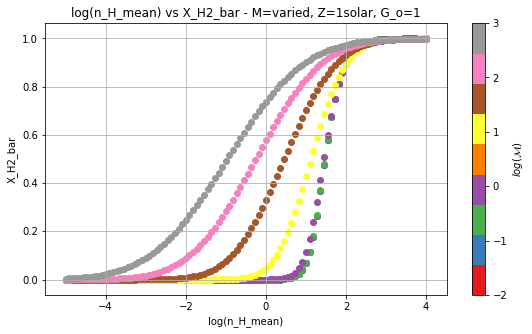

CPU times: user 25.8 s, sys: 2.51 s, total: 28.3 s
Wall time: 25.9 s


In [13]:
%%time
plt.figure(figsize=(9,5))
Z = 0.02/0.02
G_o = 1
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 8), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
for m in range(0, len(mach_no_arr)):
    mach_no = mach_no_arr[m]
    s = np.zeros(100)
    n_H = np.zeros(100)
    pdf = np.zeros(100)
    lambda_jeans = np.zeros(100)
    X_CO = np.zeros(100)
    n_CO = np.zeros(100)
    integral1 = 0
    integral2 = 0
    sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -7*sigma_s + s_bar
    smax = 7*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(0, 100):
        s[i] = smin + i*ds
    pdf = make_pdf(s, s_bar, sigma_s)
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, c_s, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_H2_bar[y], 
                      c=np.log10(mach_no), vmin=np.log10(min_M), vmax=np.log10(max_M), cmap='Set1')
#             plt.scatter(np.log10(n_H_mean), X_CO_bar[y], 
#                       c=np.log10(mach_no), vmin=np.log10(min_M), vmax=np.log10(max_M), cmap='Set2')
plt.colorbar(label=r"$log(\mathcal{M})$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_H2_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_H2_bar - M=varied, Z=1solar, G_o=1')
plt.savefig('outputs/reference_plots_1.0/X_H2_bar-n_H_mean_M.png', dpi=300, bbox_inches='tight')
plt.show()

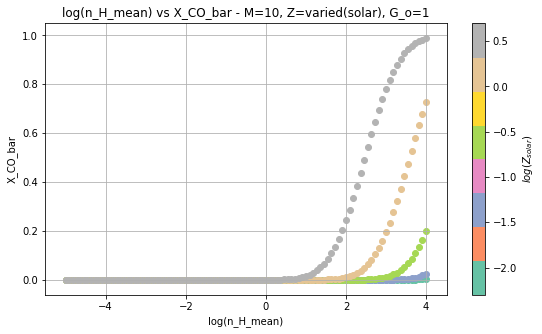

CPU times: user 16.3 s, sys: 1.54 s, total: 17.9 s
Wall time: 16.4 s


In [9]:
%%time
plt.figure(figsize=(9,5))
Z_arr = pynbody.array.SimArray(np.logspace(-4, -1, 5), '1')/0.02
G_o = 1
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no = 10
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_Z = np.min(Z_arr)
max_Z = np.max(Z_arr)


s = np.zeros(100)
n_H = np.zeros(100)
pdf = np.zeros(100)
lambda_jeans = np.zeros(100)
X_CO = np.zeros(100)
n_CO = np.zeros(100)
integral1 = 0
integral2 = 0
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = (smax - smin)/100
for i in range(0, 100):
    s[i] = smin + i*ds
pdf = make_pdf(s, s_bar, sigma_s)
for z in range(0, len(Z_arr)):
    Z = Z_arr[z]
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, c_s, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
#             plt.scatter(np.log10(n_H_mean), X_H2_bar[y], 
#                       c=np.log10(Z), vmin=np.log10(min_Z), vmax=np.log10(max_Z), cmap='Set1')
            plt.scatter(np.log10(n_H_mean), X_CO_bar[y], 
                      c=np.log10(Z), vmin=np.log10(min_Z), vmax=np.log10(max_Z), cmap='Set2')
plt.colorbar(label=r"$log(Z_{solar})$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_CO_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_CO_bar - M=10, Z=varied(solar), G_o=1')
plt.savefig('outputs/reference_plots_1.0/X_CO_bar-n_H_mean_Z.png', dpi=300, bbox_inches='tight')
plt.show()

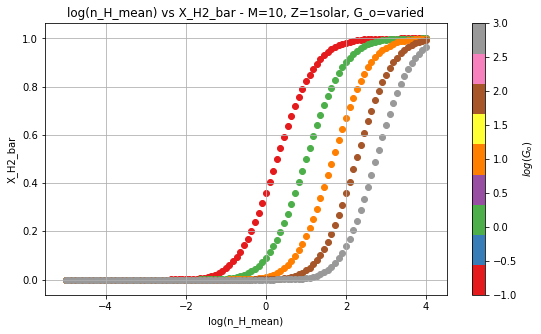

CPU times: user 16.3 s, sys: 1.63 s, total: 17.9 s
Wall time: 16.4 s


In [15]:
%%time
plt.figure(figsize=(9,5))
Z = 0.02/0.02
G_o_arr = pynbody.array.SimArray(np.logspace(-1, 3, 5), '1')
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no = 10
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_G = np.min(G_o_arr)
max_G = np.max(G_o_arr)


s = np.zeros(100)
n_H = np.zeros(100)
pdf = np.zeros(100)
lambda_jeans = np.zeros(100)
X_CO = np.zeros(100)
n_CO = np.zeros(100)
integral1 = 0
integral2 = 0
sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
s_bar = -0.5*(sigma_s**2)
smin = -7*sigma_s + s_bar
smax = 7*sigma_s + s_bar
ds = (smax - smin)/100
for i in range(0, 100):
    s[i] = smin + i*ds
pdf = make_pdf(s, s_bar, sigma_s)
for g in range(0, len(G_o_arr)):
    G_o = G_o_arr[g]
    for y in range(0, len(n_H_mean_arr)):
            n_H_mean = n_H_mean_arr[y]
            X_H2_bar[y], X_CO_bar[y] = inside_loop(mach_no, n_H_mean, Z, G_o, c_s, s, pdf, lambda_jeans, 
                                                  X_CO, n_CO, integral1, integral2, ds)
            plt.scatter(np.log10(n_H_mean), X_H2_bar[y], 
                    c=np.log10(G_o), vmin=np.log10(min_G), vmax=np.log10(max_G), cmap='Set1')
#             plt.scatter(np.log10(n_H_mean), X_CO_bar[y], 
#                       c=np.log10(G_o), vmin=np.log10(min_G), vmax=np.log10(max_G), cmap='Set2')
plt.colorbar(label=r"$log({G_o})$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_H2_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_H2_bar - M=10, Z=1solar, G_o=varied')
plt.savefig('outputs/reference_plots_1.0/X_H2_bar-n_H_mean_G_o.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
np.min(region.gas["metal"])

SimArray(0.00042521)

In [24]:
np.max(region.gas["metal"])

SimArray(0.11394659)

In [26]:
np.mean(np.logspace(-4, -1, 5))

0.024321482617149594